In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from matplotlib import pyplot as plt
from utils.freq_calculator import do_bandpass, prepare_fft
import copy


from utils.lag_calculator import (
    epoch_data,
    remove_outliers,
    replace_outliers,
    calculate_epochs_lag,
    prepare_comparison_data,
    prepare_idun_data,
    adjust_data_by_mean_lag,
    sync_start_and_equalize_data_length,
    clean_data_from_spikes,
    convert_data_to_array,
    get_device_configuration,
    cut_throughout_data_dual,
    interpolate_signal,
    smooth,
    manual_sync,
    load_edf_file,
    load_xdf_file,
    find_automatic_alignment,
    check_timestamp,
)
import config

### Upload all data

In [2]:
folder = "01_Pre_study"
subject = "S001"
night = "night1"
idun_file_ending = "eeg"


if len(glob.glob(os.path.join(folder, subject, night, "*scoring.edf"))) != 0:
    comparison_raw_data, comparison_time_stamps, file_extention = load_edf_file(
        folder, subject, night, config.PRODIGY_SAMPLE_RATE
    )
elif len(glob.glob(os.path.join(folder, subject, night, "*.xdf"))) != 0:
    print("No edf file present in the folder")

    comparison_raw_data, comparison_time_stamps, file_extention = load_xdf_file(
        folder, subject, night
    )
else:
    print("No xdf file present in the folder")


# csv_file_path = glob.glob(os.path.join(folder, subject, night, "*eeg.csv"))[0]
csv_file_path = glob.glob(
    os.path.join(folder, subject, night, f"*{idun_file_ending}.csv")
)[0]
# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=",", skip_header=1)
channel_1_key, channel_2_key, scale_factor, sample_rate = get_device_configuration(
    config
)
# print channel keys
print(channel_1_key, channel_2_key)

LEFT_EYE RIGHT_EYE


### Unpack scalp data

In [3]:
comparison_data, comparison_channel_names = convert_data_to_array(
    comparison_raw_data, file_extention
)

(
    comparison_base_data_df,
    comparison_filtered_data_rs,
    resampled_times,
) = prepare_comparison_data(comparison_data, config)
pr_freqs_rs, pr_fft_rs = prepare_fft(
    comparison_filtered_data_rs,
    config.FILTER_RANGE[0] - 5,
    config.FILTER_RANGE[1] + 5,
    config.BASE_SAMPLE_RATE,
)
# print columns of the dataframe
print(comparison_base_data_df.columns)

Index(['AUDIO', 'CHIN', 'LEFT_EEG', 'LEFT_EYE', 'MASTOID', 'POSITION',
       'RIGHT_EEG', 'RIGHT_EYE'],
      dtype='object')


Text(0.5, 1.0, 'Channel 1 - Channel 2 unfiltered')

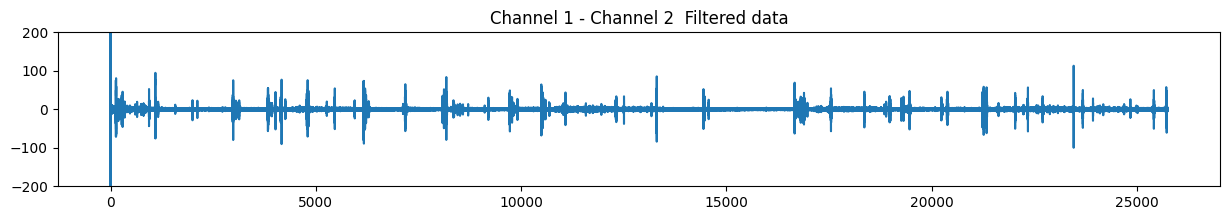

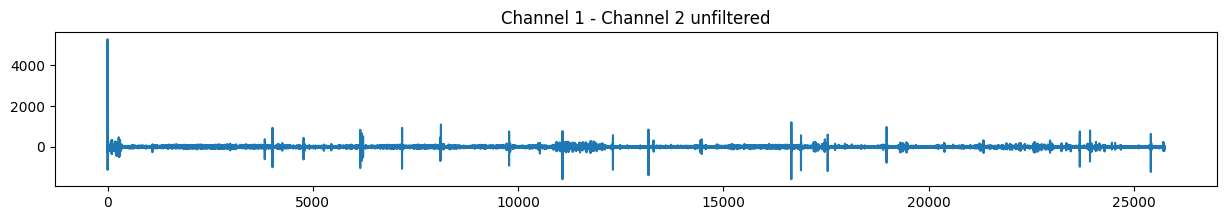

In [4]:
plt.figure(figsize=(15, 2))
plt.plot(resampled_times, comparison_filtered_data_rs)
plt.title("Channel 1 - Channel 2  Filtered data")
plt.ylim(-200, 200)
# Plot the fft of the data
plt.figure(figsize=(15, 2))
plt.plot(
    resampled_times,
    (comparison_base_data_df[channel_1_key] - comparison_base_data_df[channel_2_key])
    * scale_factor,
)
plt.title("Channel 1 - Channel 2 unfiltered")

### Unpack IDUN data

In [5]:
idun_base_data, idun_filtered_data, idun_time_stamps = prepare_idun_data(
    idun_raw_data, config
)

Text(0.5, 1.0, 'IDUN Highpassed data')

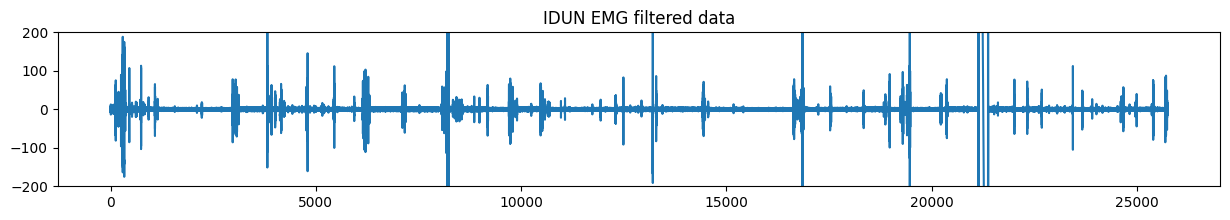

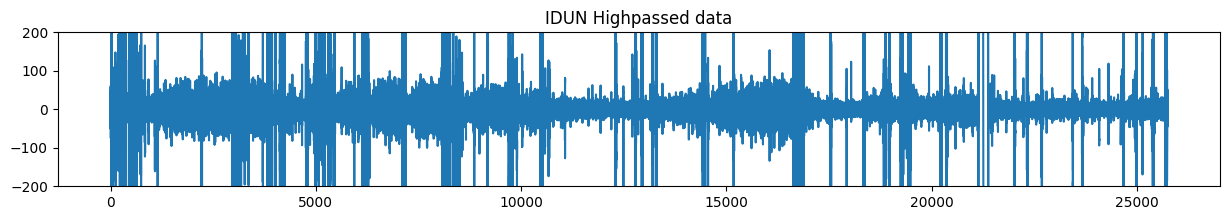

In [6]:
plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)
plt.title("IDUN EMG filtered data")

plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_base_data)
plt.ylim(-200, 200)
plt.title("IDUN Highpassed data")

### Plot together

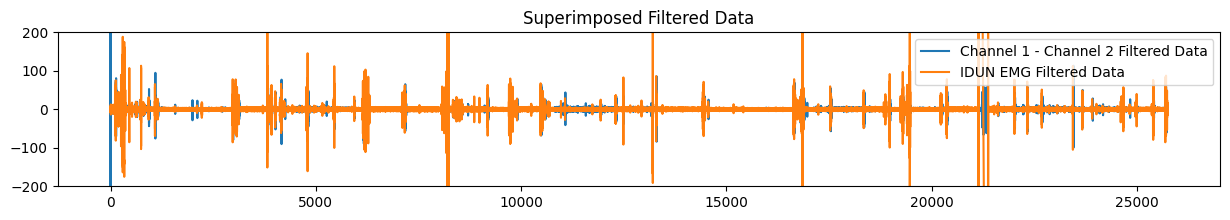

In [7]:
# Create a figure and axis
plt.figure(figsize=(15, 2))  # Adjust the figsize as needed
ax = plt.gca()
plt.plot(
    resampled_times,
    comparison_filtered_data_rs,
    label="Channel 1 - Channel 2 Filtered Data",
)
plt.plot(idun_time_stamps, idun_filtered_data, label="IDUN EMG Filtered Data")
plt.ylim(-200, 200)
# plt.xlim(7700,9000)
plt.legend(loc="upper right")
plt.title("Superimposed Filtered Data")
plt.show()

### ------------------------------------------------- Check if Manual cutting should happen -------------------------------------------------

### Do a manual sync if the data is [ > than 60 seconds misaligned ] AND [timestamp_info_available = False]

In [8]:
timestamp_info_available = check_timestamp(
    comparison_time_stamps, idun_time_stamps
)  # Automatic_alignement = True or False
print(f"timestamp_info_available = {timestamp_info_available}")

timestamp_info_available = False


In [9]:
# Do a manual sync if the data is more than 60 seconds misaligned or timestamp_info_available = False
MANUAL_SHIFT = 0  # only if True

In [10]:
(
    comparison_clipped_data_manual,
    idun_clipped_data_manual,
    idun_base_clipped_data_manual,
    comparison_base_clipped_df_manual,
    same_times,
) = manual_sync(
    comparison_filtered_data_rs,
    idun_filtered_data,
    idun_base_data,
    comparison_base_data_df,
    config,
    MANUAL_SHIFT,
)

No cutting


### Plot Zoomed in

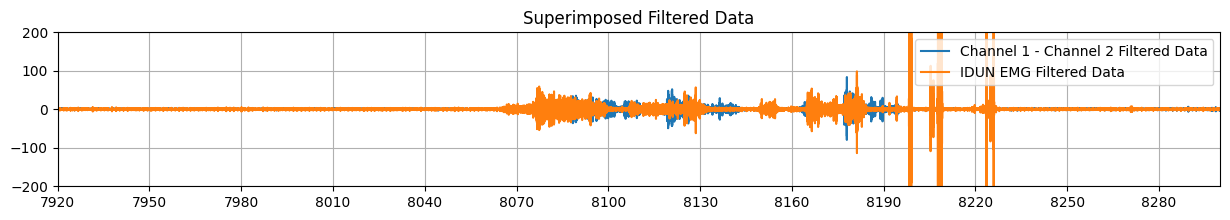

In [11]:
# Create a figure and axis
X_LIMIT = (7920, 8300)

plt.figure(figsize=(15, 2))  # Adjust the figsize as needed
ax = plt.gca()
plt.plot(
    resampled_times,
    comparison_clipped_data_manual,
    label="Channel 1 - Channel 2 Filtered Data",
)
plt.plot(idun_time_stamps, idun_clipped_data_manual, label="IDUN EMG Filtered Data")
plt.grid()
plt.ylim(-200, 200)
plt.xlim(X_LIMIT)
# make ticks have a period of 60 seconds
plt.xticks(np.arange(X_LIMIT[0], X_LIMIT[1], 30))
plt.legend(loc="upper right")
plt.title("Superimposed Filtered Data")
plt.show()

### ----------------------------------------------------------------------------------------------------------------------------------------------

### Check whether no timestamp initial sync method will be used

### Do cutting if timestamps are available

No timestamp info available, finding best alignment with iterative method

------------------------
Testing shift of: -60s
------------------------
Cutting from the end of the data idun data
End of shorter data reached


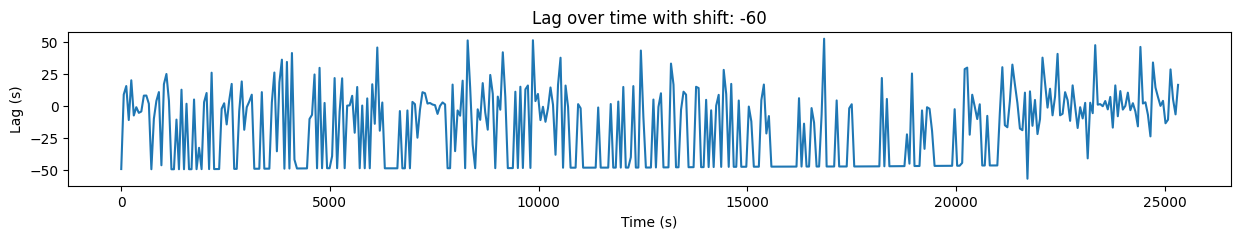

New len: 99, Old len: 422

------------------------
Testing shift of: -40s
------------------------
Cutting from the end of the data idun data
End of shorter data reached


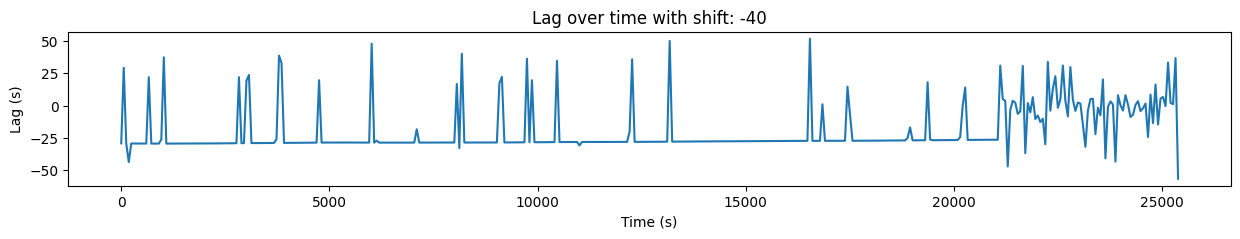

New len: 287, Old len: 423
Shift is satisfactory of amount: -40s


In [12]:
if timestamp_info_available:
    print("Timestamp info available, syncing data using initial timestamps")
    (
        comparison_clipped_data_manual,
        idun_clipped_data_manual,
        idun_base_clipped_data_manual,
        comparison_base_clipped_df_manual,
        same_times,
        timestamp_info_available,
    ) = sync_start_and_equalize_data_length(
        comparison_filtered_data_rs,
        idun_filtered_data,
        idun_base_data,
        comparison_base_data_df,
        comparison_time_stamps,
        idun_time_stamps,
        config,
    )
else:
    print("No timestamp info available, finding best alignment with iterative method")
    (
        comparison_clipped_data_manual,
        idun_clipped_data_manual,
        idun_base_clipped_data_manual,
        comparison_base_clipped_df_manual,
        same_times,
    ) = find_automatic_alignment(
        comparison_filtered_data_rs,
        idun_filtered_data,
        idun_base_data,
        comparison_base_data_df,
        config
    )

### Plot results of initial sync

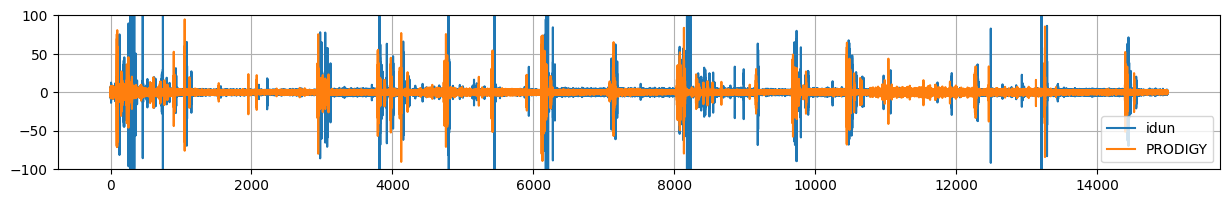

In [13]:
x_start = 0
range_viz = 15000
# create indeces from second limits
x_start_index = int(x_start * config.BASE_SAMPLE_RATE)
range_viz_index = int(range_viz * config.BASE_SAMPLE_RATE)


plt.figure(figsize=(15, 2))
plt.plot(
    same_times[x_start_index : x_start_index + range_viz_index],
    idun_clipped_data_manual[x_start_index : x_start_index + range_viz_index],
    label="idun",
)
plt.plot(
    same_times[x_start_index : x_start_index + range_viz_index],
    comparison_clipped_data_manual[x_start_index : x_start_index + range_viz_index],
    label=config.DEVICE,
)
plt.legend(loc="lower right")
plt.ylim(-100, 100)
plt.grid()

### Calculate lag first iteration

In [14]:
# extract only the first 1000 seconds
comparison_clipped_temp_data = copy.deepcopy(comparison_clipped_data_manual)
idun_clipped_temp_data = copy.deepcopy(idun_clipped_data_manual)

search_size = config.FIRST_LAG_EPOCH_SIZE

comparison_epochs = epoch_data(comparison_clipped_temp_data, search_size)
idun_epochs = epoch_data(idun_clipped_temp_data, search_size)
# extract only the f
correlation_arr, max_corr_arr, lag_arr = calculate_epochs_lag(
    comparison_epochs, idun_epochs
)
lag_arr_copy = lag_arr[1:].copy()

cleaned_initial_lag = clean_data_from_spikes(
    lag_arr, config.DISCONTINUITY_THRESHOLD
)
# remove np.nan from lag_arr_copy
lag_arr_copy = np.array(cleaned_initial_lag)
lag_arr_copy = lag_arr_copy[~np.isnan(lag_arr_copy)]
lag_initial = int(lag_arr_copy[1])

End of shorter data reached


(-39.208, -19.208)

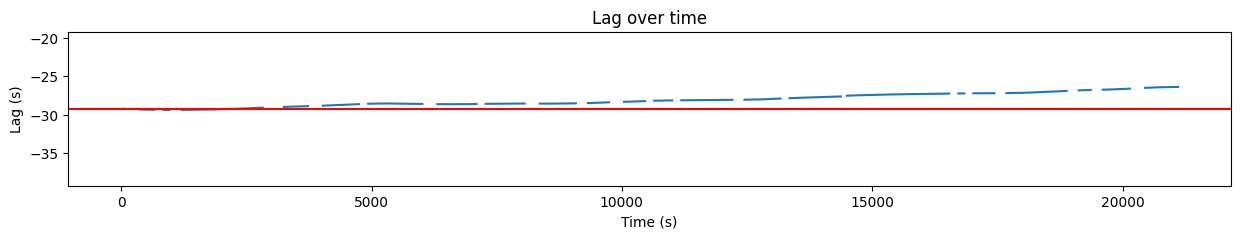

In [15]:
plt.figure(figsize=(15, 2))
# create a time array based on config.FIRST_LAG_EPOCH_SIZE and length of lag_arr_copy
plot_time_arr = np.linspace(
    0, len(cleaned_initial_lag) * config.FIRST_LAG_EPOCH_SIZE, len(cleaned_initial_lag)
)
# convert  to seconds
plot_time_arr = plot_time_arr / config.BASE_SAMPLE_RATE
plt.title("Lag over time")
plt.xlabel("Time (s)")
plt.ylabel("Lag (s)")
plt.plot(plot_time_arr, np.array(cleaned_initial_lag) / config.BASE_SAMPLE_RATE)
# plot a horizontal line at the mean lag
plt.axhline(y=lag_initial / config.BASE_SAMPLE_RATE, color="r", linestyle="-")
plt.ylim(lag_initial/ config.BASE_SAMPLE_RATE-10, lag_initial/ config.BASE_SAMPLE_RATE+10)


### Cut based on first analysis

In [16]:
# cut the lag_mean data from the start of idun_clipped_data if it is positive or from the start of  if negative
if lag_initial < 0:
    idun_cut_data = idun_clipped_data_manual[-lag_initial:]
    idun_base_cut_data = idun_base_clipped_data_manual[-lag_initial:]
    comparison_cut_data = comparison_clipped_data_manual[:-(-lag_initial)]
    comparison_base_cut_df = comparison_base_clipped_df_manual[
        :-(-lag_initial)
    ].reset_index(drop=True)
else:
    idun_cut_data = idun_clipped_data_manual[:-(lag_initial)]
    idun_base_cut_data = idun_base_clipped_data_manual[:-(lag_initial)]
    comparison_cut_data = comparison_clipped_data_manual[lag_initial:]
    comparison_base_cut_df = comparison_base_clipped_df_manual[lag_initial:].reset_index(
        drop=True
    )

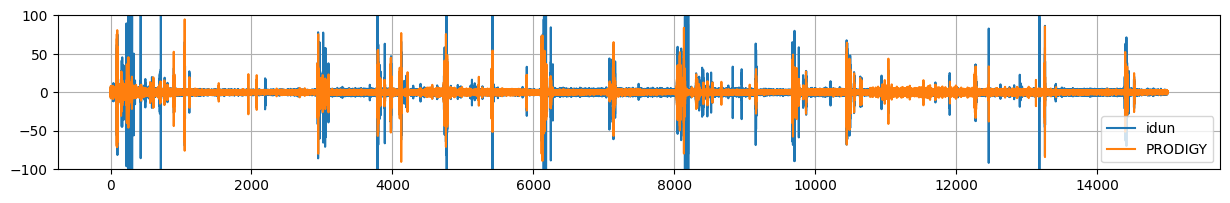

In [17]:
# plot the data
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_cut_data)) / config.BASE_SAMPLE_RATE
plt.plot(
    time_seconds[x_start_index : x_start_index + range_viz_index],
    idun_cut_data[x_start_index : x_start_index + range_viz_index],
    label="idun",
)
plt.plot(
    time_seconds[x_start_index : x_start_index + range_viz_index],
    comparison_cut_data[x_start_index : x_start_index + range_viz_index],
    label=config.DEVICE,
)
plt.legend(loc="lower right")
plt.ylim(-100, 100)
plt.grid()

### Do a more fine grained sync

In [18]:
cutted_comparisoneeg_epochs = epoch_data(
    comparison_cut_data, config.SECOND_LAG_EPOCH_SIZE
)
cutted_idun_epochs = epoch_data(idun_cut_data, config.SECOND_LAG_EPOCH_SIZE)

In [19]:
fine_correlation_arr, fine_max_corr_arr, fine_lag_arr = calculate_epochs_lag(
    cutted_comparisoneeg_epochs, cutted_idun_epochs
)
fine_lag_arr[0] = fine_lag_arr[1]  # the very first lag estimation is not accurate

End of shorter data reached


(-15.0, 15.0)

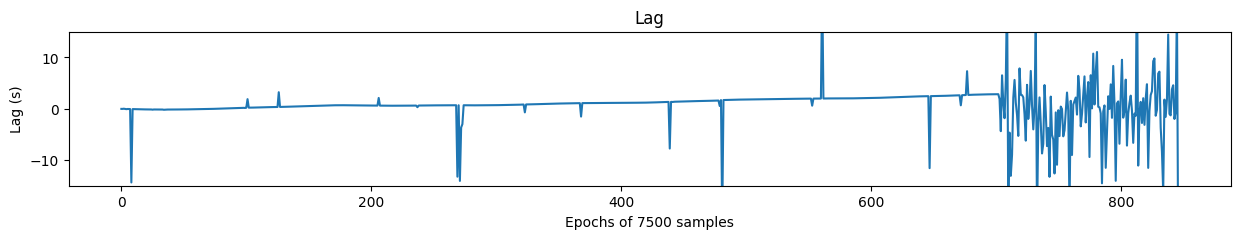

In [20]:
fine_lag_arr_copy = fine_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(fine_lag_arr_copy) / 250)
plt.title("Lag")
plt.xlabel(f"Epochs of {config.SECOND_LAG_EPOCH_SIZE} samples")
plt.ylabel("Lag (s)")
plt.ylim(-15, 15)

### Do some cleaning on lag estimation

### ------------------------------------------------------------------------------------------------

In [21]:
DISCONTINUITY_THRESHOLD = config.DISCONTINUITY_THRESHOLD
# save as txt file the correlation strictness
np.savetxt(
    os.path.join(folder, subject, night, "discontinuity_threshold.txt"),
    [DISCONTINUITY_THRESHOLD],
    delimiter=",",
)

### ------------------------------------------------------------------------------------------------

Text(0.5, 1.0, 'Lag')

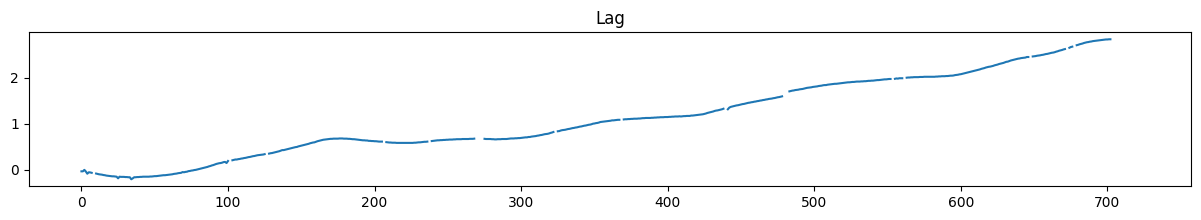

In [22]:
cleaned_fine_lag_arr = clean_data_from_spikes(
    fine_lag_arr_copy, DISCONTINUITY_THRESHOLD
)
plt.figure(figsize=(15, 2))
plt.plot(cleaned_fine_lag_arr / config.BASE_SAMPLE_RATE)
plt.title("Lag")

### Make signal whole

In [23]:
# interpolate the signal
interpolated_cleaned_fine_lag_arr = interpolate_signal(cleaned_fine_lag_arr)
smoothed_lag_arr = smooth(interpolated_cleaned_fine_lag_arr, window_size=10)

/Users/waddaben/Desktop/code/idn-sync-data/utils/lag_calculator.py:409: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s.fillna(method="bfill", inplace=True)
/Users/waddaben/Desktop/code/idn-sync-data/utils/lag_calculator.py:410: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s.fillna(method="ffill", inplace=True)


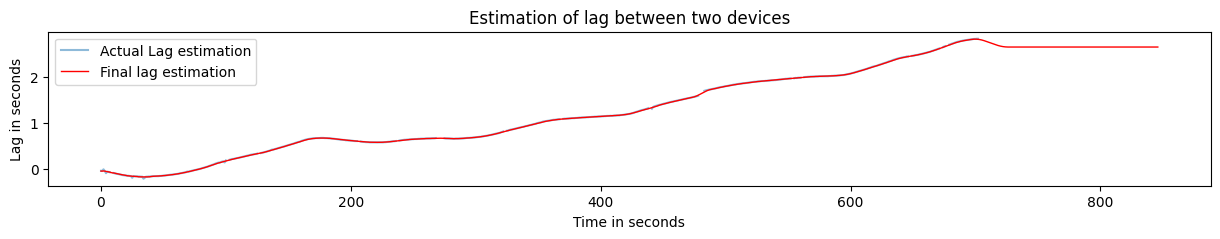

In [24]:
# Plotting the regression curve
plt.figure(figsize=(15, 2))
plt.plot(
    cleaned_fine_lag_arr / config.BASE_SAMPLE_RATE,
    label="Actual Lag estimation",
    alpha=0.5,
)
plt.plot(
    smoothed_lag_arr / config.BASE_SAMPLE_RATE,
    "r-",
    label="Final lag estimation",
    linewidth=1,
)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.savefig(
    os.path.join(folder, subject, night, "lag_estimation.png"),
    dpi=300,
    bbox_inches="tight",
)

### Create linear knots

In [25]:
x_axis_simulated = np.linspace(
    0, len(smoothed_lag_arr) - 1, len(smoothed_lag_arr)
)  # This will be 0 to 718

x_knots = np.linspace(0, len(smoothed_lag_arr) - 1, config.TOTAL_LINEAR_SEGMENTS + 1)
y_knots = smoothed_lag_arr[
    (x_knots).astype(int)
]  # Directly get the y-values from y_pred

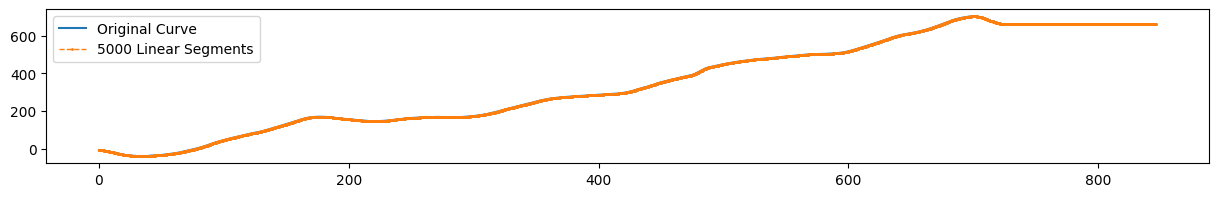

In [26]:
# Plot
plt.figure(figsize=(15, 2))
plt.plot(x_axis_simulated, smoothed_lag_arr, label="Original Curve")
plt.plot(
    x_knots,
    y_knots,
    label=f"{config.TOTAL_LINEAR_SEGMENTS} Linear Segments",
    linestyle="--",
    marker="o",
    linewidth=1,
    markersize=1,
)
plt.legend()
plt.show()

### Use the Linear lines to estimate the difference in sampling rates and apply

In [27]:
point_size = config.SECOND_LAG_EPOCH_SIZE
adjustment_epoch_size = int(len(comparison_cut_data) / config.TOTAL_LINEAR_SEGMENTS)
lag_positions = np.arange(0, len(comparison_cut_data), adjustment_epoch_size)
cumulative_lags = y_knots.astype(int)
lag_sizes = np.diff(cumulative_lags)
# make sure lag_sizes and lag_positions have the same length by cutting end of shorter one
if len(lag_sizes) > len(lag_positions):
    lag_sizes = lag_sizes[: len(lag_positions)]
elif len(lag_sizes) < len(lag_positions):
    lag_positions = lag_positions[: len(lag_sizes)]

Text(0, 0.5, 'Samples to remove')

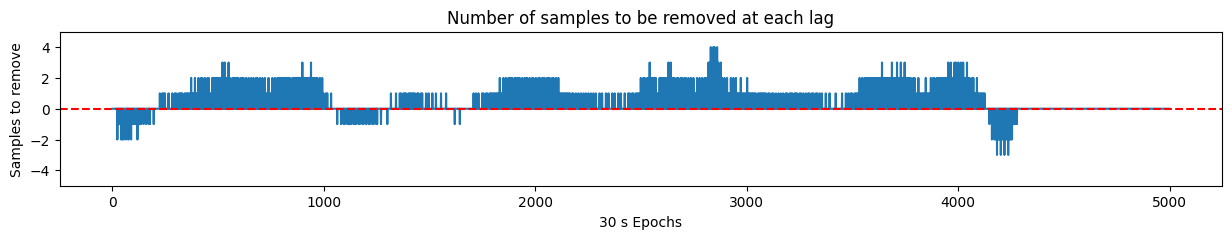

In [28]:
plt.figure(figsize=(15, 2))
plt.plot(lag_sizes)
plt.title("Number of samples to be removed at each lag")
plt.axhline(y=0, color="r", linestyle="--")
plt.ylim(-5, 5)
plt.xlabel("30 s Epochs")
plt.ylabel("Samples to remove")

### Cut the data throughout and at the end

In [29]:
(
    idun_data_pruned,
    idun_base_pruned,
    comparison_data_pruned,
    comparison_base_pruned_df,
) = cut_throughout_data_dual(
    idun_cut_data,
    idun_base_cut_data,
    comparison_cut_data,
    comparison_base_cut_df,
    lag_positions,
    lag_sizes,
)

In [30]:
final_comparison_epochs = epoch_data(
    comparison_data_pruned, config.SECOND_LAG_EPOCH_SIZE
)
final_idun_epochs = epoch_data(idun_data_pruned, config.SECOND_LAG_EPOCH_SIZE)

In [31]:
final_correlation_arr, final_max_corr_arr, final_lag_arr = calculate_epochs_lag(
    final_comparison_epochs, final_idun_epochs
)

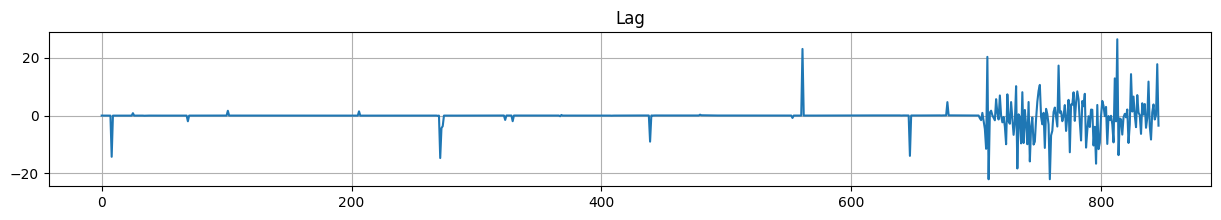

In [32]:
final_lag_arr_copy = final_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(final_lag_arr) / config.BASE_SAMPLE_RATE)
plt.title("Lag")
# plt.ylim(-0.1, 0.1)
plt.grid()

### Clean the lags

In [33]:
cleaned_final_lag_arr = replace_outliers(final_lag_arr_copy)
# rfind where the values are nan
nan_idx = np.argwhere(np.isnan(cleaned_final_lag_arr))
# remove the nan values
mean_final_lag = np.mean(np.delete(cleaned_final_lag_arr, nan_idx, axis=0))

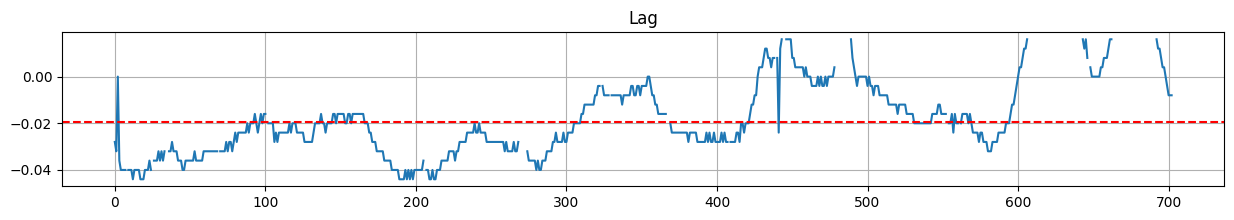

In [34]:
plt.figure(figsize=(15, 2))
plt.plot(np.array(cleaned_final_lag_arr) / config.BASE_SAMPLE_RATE)
# plot the mean_final_lag as a horizontal line
plt.axhline(y=mean_final_lag / config.BASE_SAMPLE_RATE, color="r", linestyle="--")
plt.title("Lag")
# plt.ylim(-0.2, 0.2)
plt.grid()

### Remove this final shift

In [35]:
(
    shifted_final_comparisoneeg_arr,
    shifted_final_comparisoneeg_base_df,
    shifted_final_idun_arr,
    shifted_final_idun_base_arr,
) = adjust_data_by_mean_lag(
    mean_final_lag,
    comparison_data_pruned,
    comparison_base_pruned_df,
    idun_data_pruned,
    idun_base_pruned,
)

In [36]:
shifted_final_comparisoneeg_epochs = epoch_data(
    shifted_final_comparisoneeg_arr, config.SECOND_LAG_EPOCH_SIZE
)
shifted_final_idun_epochs = epoch_data(
    shifted_final_idun_arr, config.SECOND_LAG_EPOCH_SIZE
)
(
    shifted_final_correlation_arr,
    shifted_final_max_corr_arr,
    shifted_final_lag_arr,
) = calculate_epochs_lag(shifted_final_comparisoneeg_epochs, shifted_final_idun_epochs)

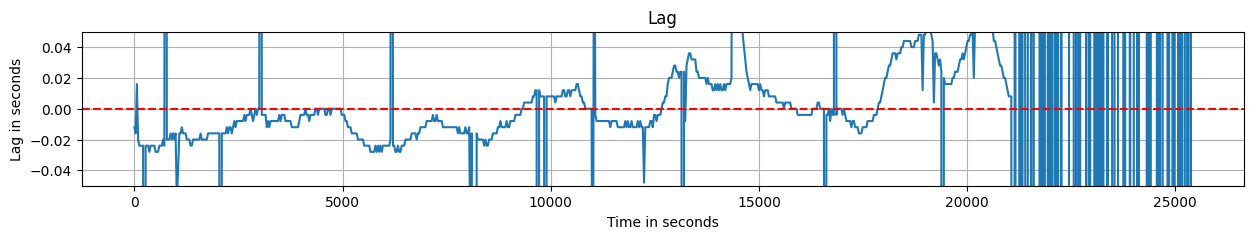

In [37]:
plt.figure(figsize=(15, 2))
# create time array kby muliplying the length of the array by the epoch size
time_seconds = (
    np.arange(len(shifted_final_lag_arr))
    * config.SECOND_LAG_EPOCH_SIZE
    / config.BASE_SAMPLE_RATE
)
plt.plot(time_seconds, np.array(shifted_final_lag_arr) / config.BASE_SAMPLE_RATE)
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Lag")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.ylim(-0.05, 0.05)
plt.grid()
# save image of lag
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_lag.png"))

### Plot final filtered data

/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


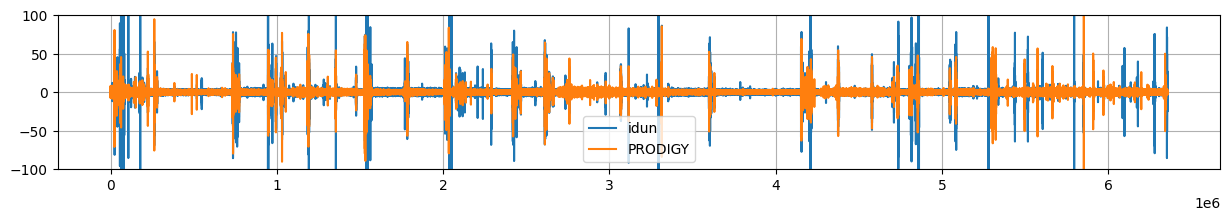

In [38]:
plt.figure(figsize=(15, 2))
# create a seconds axis
time_seconds = np.arange(len(shifted_final_idun_arr)) / config.BASE_SAMPLE_RATE
plt.plot(shifted_final_idun_arr, label="idun")
plt.plot(shifted_final_comparisoneeg_arr, label=config.DEVICE)
plt.legend()
plt.ylim(-100, 100)
plt.grid()

### Final validation, plot final raw data

(6355954, 8)
(6355954,)


/var/folders/z6/9xfx7slx70vby8pq0t9tcmk00000gn/T/ipykernel_75443/3802487502.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_raw.png"))
/var/folders/z6/9xfx7slx70vby8pq0t9tcmk00000gn/T/ipykernel_75443/3802487502.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_filtered.png"))


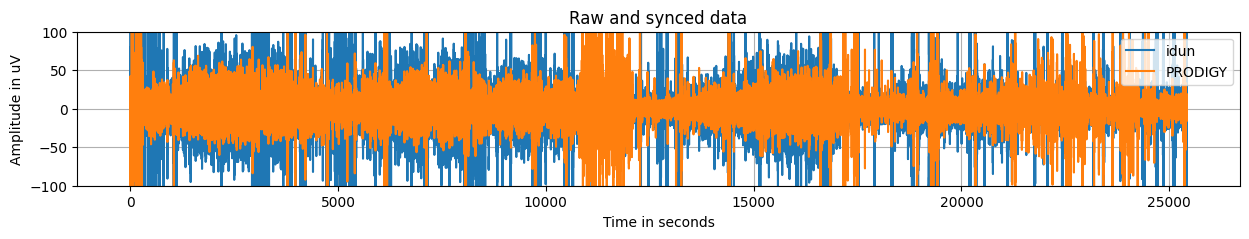

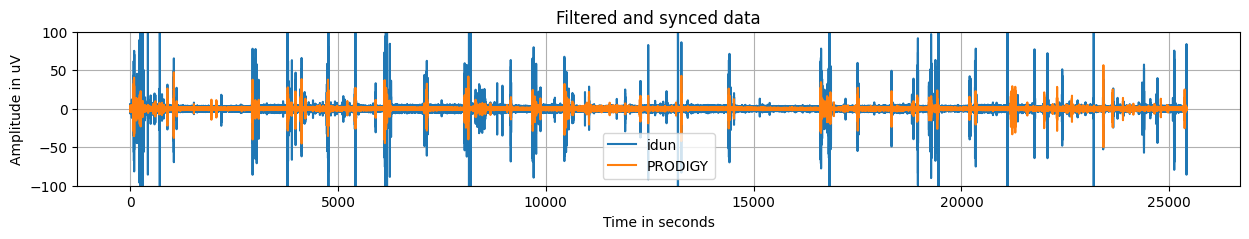

In [39]:
print(shifted_final_comparisoneeg_base_df.shape)
print(shifted_final_idun_base_arr.shape)

comparisoneeg_channel_1_data = np.array(
    shifted_final_comparisoneeg_base_df[channel_1_key]
)
comparisoneeg_channel_2_data = np.array(
    shifted_final_comparisoneeg_base_df[channel_2_key]
)
# minus right eye from left eye
comparisoneeg_channel_1_minus_2 = (
    comparisoneeg_channel_1_data - comparisoneeg_channel_2_data
)
comparisoneeg_channel_1_minus_2 = (
    comparisoneeg_channel_1_minus_2 * scale_factor
)  # To get the data to same scale as ours, v to uv

comparisoneeg_filtered = do_bandpass(
    comparisoneeg_channel_1_minus_2,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)

idun_filtered = do_bandpass(
    shifted_final_idun_base_arr,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(shifted_final_idun_base_arr)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, shifted_final_idun_base_arr, label="idun")
plt.plot(time_seconds, 0.5 * comparisoneeg_channel_1_minus_2, label=config.DEVICE)
plt.legend()
plt.title("Raw and synced data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV")
plt.ylim(-100, 100)
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_raw.png"))
plt.grid()


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, idun_filtered, label="idun")
plt.plot(time_seconds, 0.5 * comparisoneeg_filtered, label=config.DEVICE)
plt.legend()
plt.ylim(-100, 100)
plt.title("Filtered and synced data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV")
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_filtered.png"))
plt.grid()

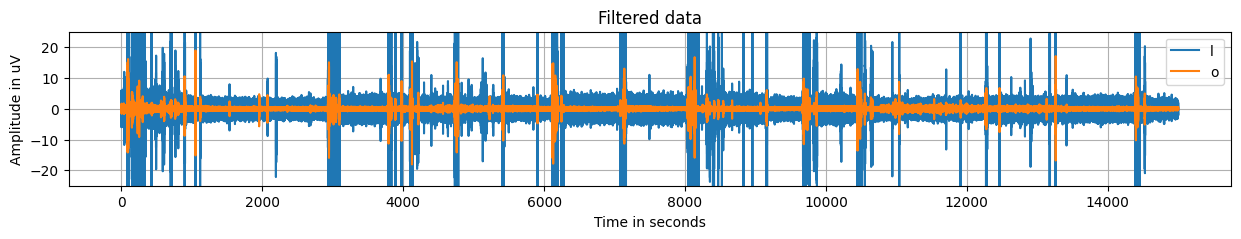

In [40]:
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered)) / config.BASE_SAMPLE_RATE
plt.plot(
    time_seconds[x_start_index : x_start_index + range_viz_index],
    idun_filtered[x_start_index : x_start_index + range_viz_index],
    label="idun",
)
plt.plot(
    time_seconds[x_start_index : x_start_index + range_viz_index],
    0.2 * comparisoneeg_filtered[x_start_index : x_start_index + range_viz_index],
    label=config.DEVICE,
)
plt.legend("lower right")
plt.ylim(-25, 25)
plt.title("Filtered data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV")
plt.grid()
plt.savefig(
    os.path.join(folder, subject, night, f"{subject}_{night}_filtered_zoom.png")
)

### Combine Dataframes

In [41]:
# create a time array based on config.BASE_SAMPLE_RATE and length of prodigy_filtered
time_array = np.linspace(
    0,
    len(shifted_final_idun_base_arr) / config.BASE_SAMPLE_RATE,
    len(shifted_final_idun_base_arr),
)
# copy the shifted_final_prodigy_base_df
synced_base_df_copy = copy.deepcopy(shifted_final_comparisoneeg_base_df)
# add shifted_final_idun_base_arr as "IDUN" column to prodigy_base_df_copy
synced_base_df_copy["IDUN"] = shifted_final_idun_base_arr
# make index of prodigy_base_df_copy as time_array
synced_base_df_copy.index = time_array

# save the dataframe as csv, and add a header indicating the sampling rate
save_path = os.path.join(folder, subject, night, f"{subject}_{night}_synced_data.csv")
synced_base_df_copy.to_csv(save_path, index=True)